In [32]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [33]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
import string

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# This function use regex and nltk to tokenize sentnece, remove stopwords and rejoined sentence again
# Input: A sentence (or an instance in a training data)
# Output: Cleaned sentence
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    clean_sentence = ' '.join(tokens)
    return clean_sentence

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tranx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tranx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tranx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
import pandas as pd
# Read csv and target the text for preprocessing
df_train = pd.read_csv("trac2_CONVT_train.csv")
columnsTrain = df_train["text"]

In [35]:
# This cell prepare token for preprocessing data in each sentence
# 1. Every sentence needs to start with <SOS> (Start of Sentence) token
# 2. Every sentence needs to end with <EOS> (End of Sentence) token
# 3. Every sentence needs to have the same length for training. Find the longest
#    sentence, store the length into a variable. Then pad all the remaining 
#    sentence with <PAD> token to ensure every other sentence has the same length
#    as the longest one
# 4. If words is not in the training sentence vocab, assign it with <UNK> token
PAD_TOKEN = "<PAD>"
EOS_TOKEN = "<EOS>"
SOS_TOKEN = "<SOS>"
UNK_TOKEN = "<UNK>"
listToken = [PAD_TOKEN, EOS_TOKEN, SOS_TOKEN, UNK_TOKEN]

In [56]:
# This cell build training vocab (include both 4 tokens from above)
# This cell also change the sentence into list of word that are used to build the vector later

emotionVocab = set()
listSentence = []
listWordVectorTrain = []
maxLengthSentence = 0


for column in columnsTrain:
    cleanColumn = clean_text(column)
    listSentence.append(cleanColumn)

for sentence in listSentence:
    listWord = sentence.split(" ")
    if "" in listWord:
        listWord.remove("")
    if len(listWord) > maxLengthSentence:
        maxLengthSentence = len(listWord)

    listWordVectorTrain.append(listWord)
    for word in listWord:
        emotionVocab.add(word)



emotionVocabList = list(emotionVocab) + listToken
sortedVocab = sorted(emotionVocabList)

In [37]:
# This function padding all the sentence in the training corpus to have the same length
# as the longest sentence (127 in this case)

def padSentence(listWordVector):
    listSentencePad = []
    for wordVector in listWordVector:
        paddedWordVector = [SOS_TOKEN] + wordVector + ([PAD_TOKEN] * (maxLengthSentence - len(wordVector))) + [EOS_TOKEN]
        listSentencePad.append(paddedWordVector)
    return listSentencePad

listSentencePadTrain = padSentence(listWordVectorTrain)

In [38]:
# Building dictionary that convert English words to integer in the training corpus vocab
# Output: {'<EOS>': 0, '<PAD>': 1, '<SOS>': 2, '<UNK>': 3, 'a': 4, 'abalone': 5, 'abandon': 6, 'abandoned': 7, 
# 'abdicated': 8, 'abdomen': 9, 'abe': 10, 'abilities': 11, 'ability': 12,...}

eng_word2int = {word: i for i, word in enumerate(sortedVocab)}


In [46]:
# Building tensor with the dictionary eng_word2int and padded corpus
# The output will be a wordTensor where each word has an integer value correctsponding to the dictionary

import numpy as np
def convertToTensor(listSentencePad):
    wordTensor = []
    for listSentence in listSentencePad:
        numericArray = []
        for word in listSentence:
            if word in eng_word2int:
                numericArray.append(eng_word2int[word])
            else:
                numericArray.append(3)
        wordTensor.append(np.array(numericArray))
    return wordTensor
    
wordTensorTrain = convertToTensor(listSentencePadTrain)
X_train = np.array(wordTensorTrain)
print(wordTensorTrain[0])

[   2 9623 2335 9873 8778   18 8789  533    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    0]


In [40]:
# For this task, I am using Glove for word embedding tasks
# The Glove file can be download in https://nlp.stanford.edu/projects/glove/
# I am using "glove.6B.300d.txt", meaning each words will be represented as 300 dimensional vectors
# The cell below build the hashmap to encode word with their correctsponding vector from the Glove file
# Input: glove.6B.300d.txt
# Output: Hashmap look like this form:
# embedding_index = { "a": [2 4 5 1 2 4 5 ...],
#                     "an": [3 1 3 5 1 2 4 ...],...}
# (Each list has 300 values since it represent 300 dimensions)


embedding_dim = 300
embedding_index = {}
with open("glove.6B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

In [41]:
# Building an embedding matrix for the training task
# The embedding matrix will have around 10000 rows (the number of unique words in training vocab) x 300 dimensions
# This embedding matrix will have the form like this:
# [[0 0 0 0 0 0 0 ...], -> 300d vector represents PAD_TOKEN (initialize to 0 vector)
#  [0 0 0 0 0 0 0 ...], -> 300d vector represents EOS_TOKEN (initialize to 0 vector)
#  [0 0 0 0 0 0 0 ...], -> 300d vector represents SOS_TOKEN (initialize to 0 vector)
#  [1 3 1 2 3 1 2 ...], -> 300d vector represents UNK_TOKEN (initialize to a random vector)
#  [...],
#  [1 2 3 1 2 3 1 ...]] -> 300d vector represents PAD_TOKEN (initialize to represented i-th words in vocab)

embedding_matrix = np.zeros((len(sortedVocab), embedding_dim))
for word, idx in eng_word2int.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector
    elif word == PAD_TOKEN or word == SOS_TOKEN or word == EOS_TOKEN:
        embedding_matrix[idx] = np.zeros(shape=(embedding_dim,))
    elif word == UNK_TOKEN :
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [42]:
# This cell build the output (Y_output) for any dataframe
# Output of regression task: Emotion Intensity (From 0-5 in ordinal scale) and Emphathy Intensity (0-5 in ordinal scale)
# Output of classficiation task: Emotional Polarity (0, 1, 2). 0 is positive, 1 is neutral and 2 is negative
from numpy import unique

def processOutput(df):
    emotionColumnIndex = df.columns.get_loc("Emotion")
    emotionPolarityColumnIndex = df.columns.get_loc("EmotionalPolarity")
    emphathyColumnIndex = df.columns.get_loc("Empathy")

    Y_reg = []
    Y_class = []
    instance = []

    for i in range(0, len(df)):
        instance.append(df.iloc[i, emotionColumnIndex])
        instance.append(df.iloc[i, emphathyColumnIndex])
        Y_reg.append(instance)
        instance = []

    for i in range(0, len(df)):
        instance.append(df.iloc[i, emotionPolarityColumnIndex])
        Y_class.append(instance)
        instance = []

    return np.array(Y_reg), np.array(Y_class)

Y_train_reg, Y_train_class = processOutput(df_train)
nClass = len(unique(Y_train_class))

In [43]:
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import LSTM, Dense

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
inputs = Input(shape=(len(wordTensorTrain[0]),))

embedding_layer = Embedding(
    input_dim = len(sortedVocab),
    output_dim = embedding_dim,
    embeddings_initializer = Constant(embedding_matrix),
    input_length = len(wordTensorTrain[0]),
    trainable=True,
)(inputs)

lstmLayers = LSTM(128, activation='tanh', dropout = 0.2)(embedding_layer)
batchNormalizeLayer = BatchNormalization()(lstmLayers)
regression_output = Dense(2, name='regression')(batchNormalizeLayer)

classification_output = Dense(nClass, activation = 'softmax', name='classification')(batchNormalizeLayer)

modelNLP = Model(inputs = inputs, outputs=[regression_output, classification_output])

modelNLP.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'regression': 'mse',
        'classification': 'categorical_crossentropy'
    },
    metrics={
        'regression': ['mse'],
        'classification': ['accuracy']
    }
)

plot_model(modelNLP, to_file='model.png', show_shapes=True)

e:\CS 421 - Project 1\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
modelNLP.fit(
    X_train, [Y_train_reg, to_categorical(Y_train_class, num_classes = nClass)],
    epochs=50,
    batch_size=32,
    validation_split=0.2,

)

modelNLP.save("RNNModel.keras")

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - classification_accuracy: 0.9280 - classification_loss: 0.2147 - loss: 0.6263 - regression_loss: 0.4115 - regression_mse: 0.4116 - val_classification_accuracy: 0.6019 - val_classification_loss: 1.5962 - val_loss: 2.3131 - val_regression_loss: 0.7366 - val_regression_mse: 0.7361
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - classification_accuracy: 0.9439 - classification_loss: 0.1775 - loss: 0.5883 - regression_loss: 0.4107 - regression_mse: 0.4108 - val_classification_accuracy: 0.6109 - val_classification_loss: 1.5582 - val_loss: 2.2538 - val_regression_loss: 0.7101 - val_regression_mse: 0.7104
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - classification_accuracy: 0.9413 - classification_loss: 0.1822 - loss: 0.5901 - regression_loss: 0.4079 - regression_mse: 0.4079 - val_classification_accuracy: 0.6096 - val_classification_loss: 1.5488 - val_loss: 2.2377 - val_regression_loss: 0.7046 - val_regression_mse: 0.7060
E

In [50]:
df_test = pd.read_csv("trac2_CONVT_dev.csv")
df_test["EmotionalPolarity"] = np.ceil(df_test['EmotionalPolarity'])
columnsTest = df_test["text"]
cleanColumn = []
listSentenceTest = []

for column in columnsTest:
    cleanColumn = clean_text(column)
    listSentenceTest.append(cleanColumn)
listWordVectorTest = []
for sentence in listSentenceTest:
    listWord = sentence.split(" ")
    if "" in listWord:
        listWord.remove("")
    listWordVectorTest.append(listWord)
listWordVectorTest[0:5]

listSentencePadTest = padSentence(listWordVectorTest)
wordTensorTest = convertToTensor(listSentencePadTest)
X_test = np.array(wordTensorTest)
print(wordTensorTest[0])

[   2 4041 4201  498 9873    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    0]


In [51]:
Y_test_reg, Y_test_class = processOutput(df_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step


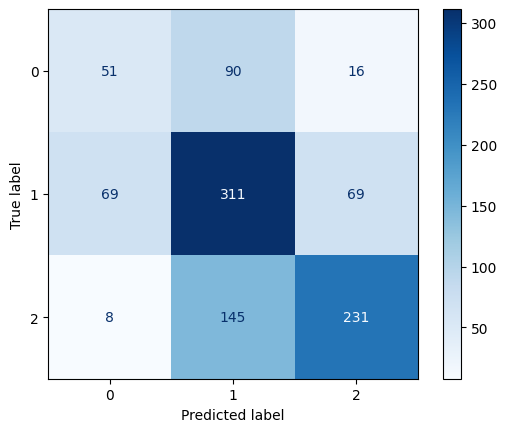

MSE per output: [0.55666727 1.14004515]
RMSE per output: [0.74610138 1.06772897]
MAE per output: [0.5868087  0.87731581]
Precision: 0.6051
Recall:    0.5990
F1 Score:  0.5963
Accuracy:  0.5990


In [52]:
# Predict Y_pred and compare with Y_test, and build confusion matrix as well as compute stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

modelNLP = load_model("RNNModel.keras")

y_pred = modelNLP.predict(X_test)
y_reg_pred = y_pred[0]
y_class_pred = np.argmax(y_pred[1], axis=1)


mse = mean_squared_error(Y_test_reg, y_reg_pred, multioutput='raw_values')

rmse = np.sqrt(mse)

mae = mean_absolute_error(Y_test_reg, y_reg_pred, multioutput='raw_values')

cm = confusion_matrix(Y_test_class, y_class_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

precision = precision_score(Y_test_class, y_class_pred, average = "weighted")

recall = recall_score(Y_test_class, y_class_pred, average = "weighted")

f1 = f1_score(Y_test_class, y_class_pred, average = "weighted")

accuracy = accuracy_score(Y_test_class, y_class_pred)

print("MSE per output:", mse)

print("RMSE per output:", rmse)

print("MAE per output:", mae)

print(f"Precision: {precision:.4f}")

print(f"Recall:    {recall:.4f}")

print(f"F1 Score:  {f1:.4f}")

print(f"Accuracy:  {accuracy:.4f}")

In [54]:
df_infer = pd.read_csv("trac2_CONVT_test.csv")

columnsInfer = df_infer["text"]
cleanColumn = []
listSentenceInfer = []

for column in columnsInfer:
    cleanColumn = clean_text(column)
    listSentenceInfer.append(cleanColumn)
listWordVectorInfer = []
for sentence in listSentenceInfer:
    listWord = sentence.split(" ")
    if "" in listWord:
        listWord.remove("")
    listWordVectorInfer.append(listWord)

listSentencePadInfer = padSentence(listWordVectorInfer)
wordTensorInfer = convertToTensor(listSentencePadInfer)
X_infer = np.array(wordTensorInfer)
print(wordTensorInfer[0])

[   2 9832 4322 8101 1147 1298 5022 2512 4607 5334 8729 5624 4271 2535
 4869 9623 8881 8778 6010 3262   18 8789  533    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    0]


In [55]:
ID = df_infer["id"]

y_infer = modelNLP.predict(X_infer)

y_reg_infer = y_infer[0]
y_class_infer = np.argmax(y_infer[1], axis=1)


df_pred = pd.DataFrame({
    "ID": ID,
    "Emotion": y_reg_infer[:, 0],
    "EmotionalPolarity": y_class_infer,
    "Empathy": y_reg_infer[:, 1]
})


df_pred.to_csv("predictions_rnn.csv", index=False)

73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step
